In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Load Data

In [ ]:
SolarPrediction = pd.read_csv('SolarPrediction.csv',',')    ## read data from csv file
data = pd.DataFrame(SolarPrediction)   ## transforming into data frame
features = ["UNIX","Date","Time","Radiation","Temperature","Pressure","Humidity","Wind_Direction","Speed","Sun_Rise","Sun_Set"]
data.columns = features   ## changing column names for ease
data["Date"] = data["Date"].str.split(" ", n = 1, expand = True)[0]  ## getting rid of unnecessary strings
data.drop_duplicates(subset=None, keep='first', inplace=True)   ## dropping duplicate entries
data

,UNIX,Date,Time,Radiation,Temperature,Pressure,Humidity,Wind_Direction,Speed,Sun_Rise,Sun_Set
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


### Data Validation

In [ ]:
data["Time"] = pd.to_timedelta(data["Time"])                ## validating time format
data["Sun_Rise"] = pd.to_timedelta(data["Sun_Rise"])              ## validating time format
data["Sun_Set"] = pd.to_timedelta(data["Sun_Set"])             ## validating time format
data["Time_from_Sunrise"] = abs(data["Time"]-data["Sun_Rise"]).dt.total_seconds().div(60).astype(int) 
data["Time_to_Sunset"] = abs(data["Sun_Set"] - data["Time"]).dt.total_seconds().div(60).astype(int)
# data['Length_of_Day'] = data['Length_of_Day'].dt.total_seconds().div(60).astype(int)  ## length of the day in minutes
data['Time'] = data['Time'].dt.total_seconds().div(60).astype(int)                    ## Time column in minutes

''' 
Key and Date are dropped and 10 quantitative features are selected for linear regression calculation into new dataframe as following
'''
df = pd.DataFrame(data[["UNIX","Time","Radiation","Temperature","Pressure", "Humidity", "Wind_Direction","Speed", "Time_from_Sunrise","Time_to_Sunset"]])
df

,UNIX,Time,Radiation,Temperature,Pressure,Humidity,Wind_Direction,Speed,Time_from_Sunrise,Time_to_Sunset
0,1475229326,1435,1.21,48,30.46,59,177.39,5.62,1062,342
1,1475229023,1430,1.21,48,30.46,58,176.78,3.37,1057,337
2,1475228726,1425,1.23,48,30.46,57,158.75,3.37,1052,332
3,1475228421,1420,1.21,48,30.46,60,137.71,3.37,1047,327
4,1475228124,1415,1.17,48,30.46,62,104.95,5.62,1042,322
...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,20,1.22,44,30.43,102,145.42,6.75,380,1041
32682,1480587301,15,1.17,44,30.42,102,117.78,6.75,385,1046
32683,1480587001,10,1.20,44,30.42,102,145.19,9.00,390,1051
32684,1480586702,5,1.23,44,30.42,101,164.19,7.87,395,1056


### Data Normalization

In [ ]:
''' 
Normalizing with formula: X(i) = (X(i) - X(min) / (X(max) - X(min))
Taking 'Radiation' as output feature

'''

for column in df.columns:
    ## no normalization needed for output, i.e: Radiation column
    if column != "Radiation":                                                 
        df[column] = (df[column]-df[column].min())/(df[column].max()-df[column].min())
df.head()

,UNIX,Time,Radiation,Temperature,Pressure,Humidity,Wind_Direction,Speed,Time_from_Sunrise,Time_to_Sunset
0,0.237685,0.999304,1.21,0.378378,0.72973,0.536842,0.492692,0.138765,0.994382,0.306177
1,0.237656,0.995822,1.21,0.378378,0.72973,0.526316,0.490996,0.083210,0.989700,0.301701
2,0.237628,0.992340,1.23,0.378378,0.72973,0.515789,0.440894,0.083210,0.985019,0.297225
3,0.237599,0.988858,1.21,0.378378,0.72973,0.547368,0.382426,0.083210,0.980337,0.292748
4,0.237571,0.985376,1.17,0.378378,0.72973,0.568421,0.291391,0.138765,0.975655,0.288272


### Linear Regression: Multiple features

Intercept Value (W0): -790.3219709432859 
Feature Coefficients(Wi): [ 233.87451245  594.09508028 1614.74364449 -172.05295712   61.53890308
 -105.78958973  198.04356218 -547.79858245  337.53306779] 
Predicted Outputs: [ -88.59967817 -101.09214208  -97.46102053 ... -102.45820205 -117.34607094
 -123.43560461]
R-Square: 0.6612983091210006


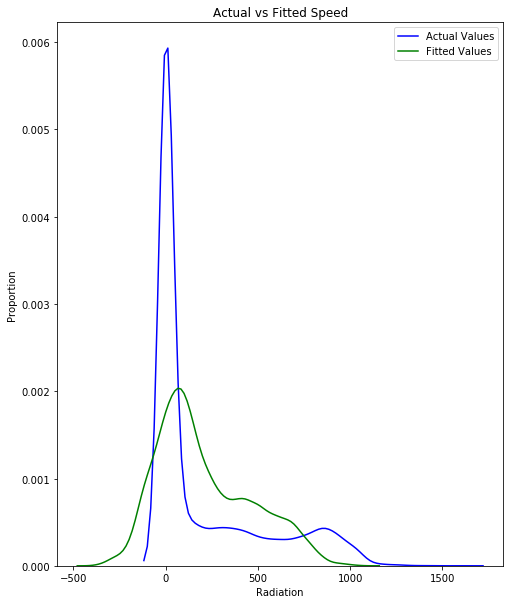

In [ ]:
lr = LinearRegression()
x = df[['UNIX','Time','Temperature','Pressure','Humidity','Wind_Direction','Speed','Time_from_Sunrise', 'Time_to_Sunset']]   ## inputes
y = df['Radiation']               ## output
lr.fit(x,y)                 ## multiple linear regressing fit 
yhat = lr.predict(x)
intercept = lr.intercept_  ## retreiving w0
coefficient = lr.coef_      ## retrieving w1, w2, ...
dff = pd.DataFrame(intercept, coefficient,yhat)
print('Intercept Value (W0):',intercept,'\nFeature Coefficients(Wi):', coefficient,'\nPredicted Outputs:', yhat)
print('R-Square:',lr.score(x,y))

import seaborn as sns
plt.figure(figsize=(8,10))
ax1=sns.distplot(df['Radiation'],hist=False,color="b",label="Actual Values")     ## actual 'Y'
sns.distplot(yhat,hist=False,color="g",label="Fitted Values",ax=ax1)               ## predicted 'Y'

plt.title("Actual vs Fitted Speed")
plt.xlabel("Radiation")
plt.ylabel("Proportion")

plt.show()
plt.close()

### Polynomial Fit

           5             4            3             2
1.317e+04 x - 4.554e+04 x + 5.23e+04 x - 2.298e+04 x + 4098 x - 223.4


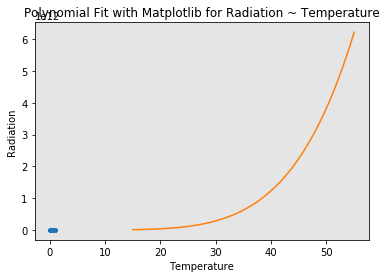

In [ ]:
z = df['Temperature']   ## taking only one feature for testing
y = df['Radiation']    
#Let's fit the polynomial using the function polyfit,then use the function to display the polynomial function.
f = np.polyfit(z, y, 5)    ## trying to fit 5 degree
p = np.poly1d(f)
print(p)

def PlotPolly(model, independent_variable, dependent_variabble, Name):
    x_new = np.linspace(15, 55, 100)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Radiation ~ Temperature')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Radiation')

    plt.show()
    plt.close()
PlotPolly(p, z, y, 'Temperature')

In [ ]:
pr=PolynomialFeatures(degree=3)
x_pr = pr.fit_transform(x)
print(x.shape, x_pr.shape)

(32686, 9) (32686, 220)


### Train/Test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

input_value = df.drop('Radiation', axis = 1)
output_value = df['Radiation'] 

'''taking 80% as train and 20% as test'''
x_train, x_test, y_train, y_test = train_test_split(input_value, output_value, test_size=0.2, random_state=1)   
lre = LinearRegression()

'''fitting train model'''
lre.fit(x_train, y_train)
print("Number of test samples :", x_test.shape[0])
print("Number of training samples:",x_train.shape[0])
print('R-Square for 80:20/Train:Test:',lre.score(x_test, y_test))

Number of test samples : 6538
Number of training samples: 26148
R-Square for 80:20/Train:Test: 0.6557259635684437


### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

yhat_cv = cross_val_predict(lre,input_value, output_value, cv=4)     ## returns best 'Yhat' from validation
Rcross = cross_val_score(lre, input_value, output_value, cv=4)              ## R square

# print('Outputs on cross validation:',yhat_cv)
print('R-Square on 4 folds cross validation:',Rcross)

R-Square on 4 folds cross validation: [0.65534878 0.64832205 0.68205232 0.45635802]


### Plotting

In [ ]:
from IPython.display import display
from IPython.html import widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

def DistributionPlot(Redfunction,Bluefunction,RedName,BlueName,Title):
    width = 12
    height = 10
    plt.figure(figsize=(width,height))
    
    ax1  = sns.distplot(Redfunction, hist=False, color="r", label=RedName)
    ax2  = sns.distplot(Bluefunction, hist=False, color="b", label=BlueName, ax=ax1)
    
    plt.title(Title)
    plt.xlabel('Radiation')
    plt.ylabel('Proportion')
    
    plt.show()
    plt.close()
    
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Radiation')
    plt.legend()

c:\users\stan\appdata\local\programs\python\python37\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Over/Under Fitting

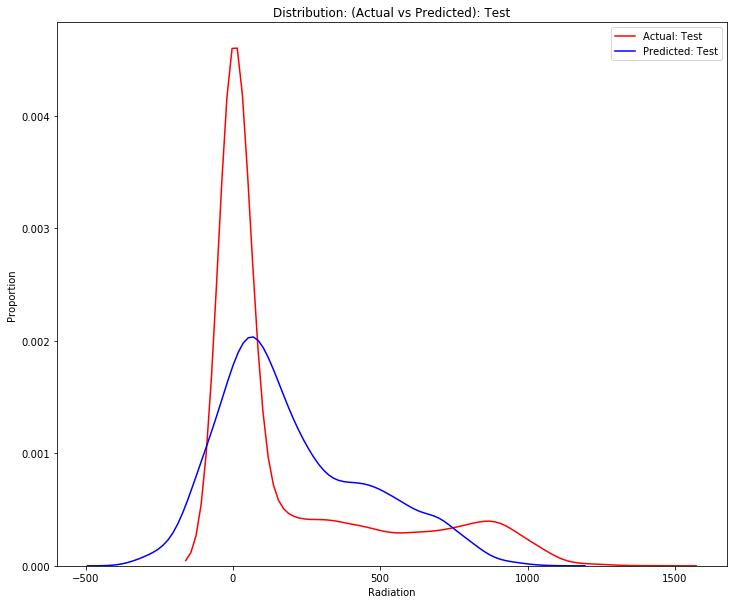

In [ ]:
lr.fit(x_train,y_train)
yhat_train = lr.predict(x_train)
yhat_test = lr.predict(x_test)

import matplotlib.pyplot as plt
import seaborn as sns

# DistributionPlot(y_train, yhat_train, "Actual: Train", "Predicted: Train", "Distribution: (Actual vs Predicted): Train")
DistributionPlot(y_test, yhat_test, "Actual: Test", "Predicted: Test", "Distribution: (Actual vs Predicted): Test")

#### Polynomial fit with 'n' degree: all features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
pr = PolynomialFeatures(degree=5)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 0)

'''transforming linear data into polynomial input'''
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
poly = LinearRegression()

'''fitting polynomial inputs into linear regression'''
poly.fit(x_train_pr, y_train)
yhat= poly.predict(x_test_pr)
print("Predicted values:", yhat[0:4],'..')
print("Actual values:", y_test[0:4].values,'..')
print('R-Square for Poly Fit:',poly.score(x_test_pr, y_test))
# PollyPlot(x_train, x_test, y_train, y_test, poly,pr)
print('Intercept for poly fit:', poly.intercept_)
print('Polynomial coeffieicnets:',poly.coef_[:3].astype('int'),'.....')

Predicted values: [470.06517713 181.34899913 804.10436056  -9.37129465] ..
Actual values: [477.77 399.87 910.28   1.22] ..
R-Square for Poly Fit: 0.9102368859675823
Intercept for poly fit: 590075.2007373313
Polynomial coeffieicnets: [      -29  -4748439 -63610439] .....


#### R-square for different polynomial degrees

In [ ]:
Rsquare_test = []
best_score = 0         ## will be replaced by best Rsquare found
order = [1,2,3,4,5]    ## only upto 5 degrees, upper degrees are not considered becaue of higher runtime
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train)
    x_test_pr = pr.fit_transform(x_test)
    
    lr.fit(x_train_pr,y_train)
    score = lr.score(x_test_pr,y_test)
    if score >= best_score:
        best_score = score
        x_train_best_poly = x_train_pr
    Rsquare_test.append(score)
    
print('Best R-Square is:',best_score)

Best R-Square is: 0.9102368859675823


#### Cross validation for polynomial fit

In [ ]:
''' As runtime for cross validation for each degree of polynomial was high
I only cross validated best polynomial fit for first '5' degrees of polynomial'''

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

yhat_cv = cross_val_predict(lr,x_train_best_poly, y_train, cv=4)
Rcross = cross_val_score(lr,x_train_best_poly, y_train, cv=4)              ## R square

# print('Outputs on cross validation:',yhat_cv)
print('R-Square on 4 folds cross validation:',Rcross)

R-Square on 4 folds cross validation: [0.90576437 0.91239686 0.90663208 0.91965929]


In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(lr, x_train_best_poly, y_train, cv=4, return_estimator=True)
dfff = pd.DataFrame(cv_results)
dfff

,fit_time,score_time,estimator,test_score
0,13.251377,0.037351,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.905764
1,12.821385,0.031249,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.912397
2,12.632670,0.032398,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.906632
3,13.660466,0.032787,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.919659


#### Plot R-square for different polynomial degrees

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(lr, x_train_best_poly, y_train, cv=4, return_estimator=True)
best_score = max(Rcross)
intercept = []
coefficients = []
for i in cv_results['estimator']:
    intercept.append(i.intercept_)
    coefficients.append(i.coef_)
dfff["Intercept"] = intercept
dfff["Coefficients"] = coefficients
best_cv = dfff.loc[dfff["test_score"] == best_score]
print('Best Rsquare after cross validation:',best_score)
print('Best intercept after cross validation:', best_cv['Intercept'].values)
print('Best coefficients after cross validation:', best_cv['Coefficients'].values)

Best Rsquare after cross validation: 0.9196592879670951
Best intercept after cross validation: [1520909.59874533]
Best coefficients after cross validation: [array([-6.41617215e+01, -6.46248261e+06, -4.66227505e+07, ...,
       -3.62017227e+08,  1.52042981e+08, -5.79823040e+06])]


#### 6th degree polynomial

In [ ]:
'''It has very high runtime
5th degree already has very good Rsquare hence we may take 5th degree as best fit
'''


# Rsquare_test = []
# best_score = 0
# pr = PolynomialFeatures(degree=6)

# x_train_pr = pr.fit_transform(x_train)
# x_test_pr = pr.fit_transform(x_test)

# lr.fit(x_train_pr,y_train)
# score = lr.score(x_test_pr,y_test)
# if score >= best_score:
#     best_score = score
#     x_train_best_poly = x_train_pr
# Rsquare_test.append(score)

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_val_predict

# yhat_cv = cross_val_predict(lr,x_train_best_poly, y_train, cv=4)
# Rcross = cross_val_score(lr,x_train_best_poly, y_train, cv=4) 
# from sklearn.model_selection import cross_validate
# cv_results = cross_validate(lr, x_train_best_poly, y_train, cv=4, return_estimator=True)
# dfff = pd.DataFrame(cv_results)
# best_score = max(Rcross)
# intercept = []
# coefficients = []
# for i in cv_results['estimator']:
#     intercept.append(i.intercept_)
#     coefficients.append(i.coef_)
# dfff["Intercept"] = intercept
# dfff["Coefficients"] = coefficients
# best_cv = dfff.loc[dfff["test_score"] == best_score]
# print('Best Rsquare after cross validation:',best_score)
# print('Best intercept after cross validation:', best_cv['Intercept'].values)
# print('Best coefficients after cross validation:', best_cv['Coefficients'].values)

'It has very high runtime\n5th degree already has very good Rsquare hence we may take 5th degree as best fit\n'

<module 'matplotlib.pyplot' from 'c:\\users\\stan\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

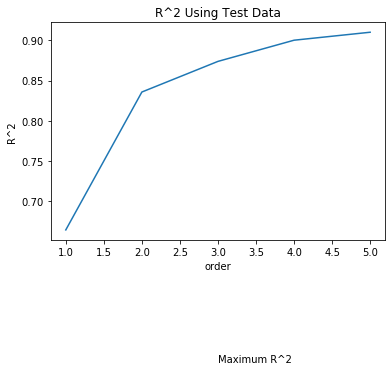

In [ ]:
'''different Rsquare for different orders of polynomial'''

plt.plot(order,Rsquare_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3,0.5,'Maximum R^2')
plt

### Ridge regression : Regularization

In [ ]:
from sklearn.linear_model import Ridge

pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train)
x_test_pr = pr.fit_transform(x_test)
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(x_train_pr, y_train)
yhat = ridge_model.predict(x_test_pr)
print('Ridge Intercept:',ridge_model.intercept_)
print('Ridge Coefficient:',ridge_model.coef_[:3].astype('int'),'..')
print('Ridge R-Square:', ridge_model.score(x_test_pr, y_test))
print('Ridge :Y_predicted:', yhat[0:4])
print('Y test set :', y_test[0:4].values)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

yhat_cv = cross_val_predict(ridge_model,x_train_pr, y_train, cv=4)
Rcross = cross_val_score(ridge_model,x_train_pr, y_train, cv=4)

from sklearn.model_selection import cross_validate
cv_results = cross_validate(ridge_model, x_train_best_poly, y_train, cv=4, return_estimator=True)
DF = pd.DataFrame(cv_results)
best_score = max(Rcross)
intercept = []
coefficients = []
for i in cv_results['estimator']:
    intercept.append(i.intercept_)
    coefficients.append(i.coef_)
DF["Intercept"] = intercept
DF["Coefficients"] = coefficients
best_cv = DF.loc[dfff["test_score"] == best_score]
print(DF)

   fit_time  score_time                                          estimator  \
0  9.449000    0.076771  Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr...   
1  7.484672    0.081783  Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr...   
2  7.907092    0.081782  Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr...   
3  8.004531    0.081784  Ridge(alpha=0.1, copy_X=True, fit_intercept=Tr...   

   test_score   Intercept                                       Coefficients  
0    0.887921  205.171927  [0.0, -40.22987525186374, 51.526509003693675, ...  
1    0.891318  182.074213  [0.0, -68.12370067585954, 39.99716358197974, 3...  
2    0.886372  126.210088  [0.0, -55.3655569887857, 57.3777687027745, 353...  
3    0.900668  262.110573  [0.0, -102.259833967993, 52.53523496175614, 29...  
